INF6804 Vision par ordinateur
Polytechnique Montréal

Original author: Soufiane Lamghari
Modified by: Arnaud Dalbec-Constant & Félix Auger

Modifications: Added scoring metrics such as UOI and F1 score with a loop function to analyse and compile the performance of the segmentation model on all of the images in a dataset.

Description : This notebook implements Mask R-CNN for instance segmentation (and object detection) in inference, using ResNet50 as the backbone network (pre-trained on the 80 classes of MS COCO). 

Import libraries

In [2]:
import torchvision.models as models
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import urllib.request as request
import random
import cv2
from PIL import Image
from skimage import io

Load the model and get the predictions, the backbone network is ResNet50 pre-trained on the 80 classes of MS COCO.

In [6]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Custom functions

In [8]:
# This function is used to draw the predicted masks over the RGB source images
def draw_colored_masks(image):
  name_colors=list(mcolors.CSS4_COLORS.keys())
  name_colors.remove('black')
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  rgb_color = rgb_colors[random.randrange(0,len(rgb_colors))]
  r[image > 0.5], g[image > 0.5], b[image > 0.5] = rgb_color
  colored_mask = np.stack([r, g, b], axis=2)

  return colored_mask, rgb_color

# This function measures the IOU score
def IOU_score(ground_truth, detection_img):
  intersection = np.count_nonzero(np.logical_and(detection_img, ground_truth))
  union = np.count_nonzero(np.logical_or(detection_img, ground_truth))
    
  iou_score = intersection / union if union != 0 else 0
  return intersection, union, iou_score

# This function measures the F1 score
def F1_score(ground_truth, detection_img):
  true_positives = np.count_nonzero(np.logical_and(detection_img, ground_truth))
  false_positives = np.count_nonzero(np.logical_and(detection_img, np.logical_not(ground_truth)))
  false_negatives = np.count_nonzero(np.logical_and(np.logical_not(detection_img), ground_truth))
    
  precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0 
  recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0 
    
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
  return f1_score, precision, recall
  

Automation of the grid search for filtered and unfiltered labels

In [ ]:
THRESHOLDS = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] # 
datasets = ['highway','pedestrians','office','PETS2006']
# ------------------------------------------------------------------
#execution_type = 'unfiltered' # or filtered
exec_types = ['unfiltered','filtered']
# ------------------------------------------------------------------

for execution_type in exec_types:                       
    for dataset_name in datasets:
        path = r'C:\Users\arnau\OneDrive\Documents\GitHub\TP_INF6804\TP2\dataset\baseline'
        path_dataset = os.path.join(path, dataset_name)
        
        with open(os.path.join(path_dataset, 'temporalROI.txt'), 'r') as file:
            temporal_values = file.readline().strip().split()
            
        temp_min, temp_max = map(int, temporal_values)
        
        full_path = os.path.join(path_dataset, 'input')
        full_path_gt = os.path.join(path_dataset, 'groundtruth')
        
        filtered_files = [filename for filename in os.listdir(full_path) if (int(filename[2:8]) >= temp_min and int(filename[2:8]) <= temp_max)]

        preprocess = transforms.Compose([transforms.ToTensor()])
        model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()
        summary_result_df = pd.DataFrame(columns = ['Threshold','UOI','F1','precision','recall'])
        i = 0
        for THRESHOLD in THRESHOLDS:
            result_df = pd.DataFrame(columns = ['image','UOI','F1_precision_recall'])
            for image_name in filtered_files:
                i = i + 1
                if i == 20:
                    i = 1
                    tensors = []
                    image_path = full_path + '/' + image_name
                    gt_path = full_path_gt + '/gt' + image_name[-10:-3] + 'png'
                
                    img = io.imread(image_path)
                    img_gt = (io.imread(gt_path) != 0).astype(int)
                
                    tensors.append(preprocess(img))
                    
                    prediction = model(tensors)[0]
                    image = tensors[0].permute(1,2,0).mul(255).byte().numpy() # permute est equivalent a faire deux tranpose : ici permute(1,2,0) peut etre remplacee par transpose(0, 1).transpose(1, 2)
                    image[:,:] = 0
                    nb_objects=0
                    
                    for j, score in enumerate(prediction['scores']):
                        if score >= THRESHOLD: 
                            mask = prediction['masks'][j][0].detach().numpy()
                            colored_mask, color = draw_colored_masks(mask)
                            
                            if execution_type == 'filtered':
                                object_label = 1
                                if dataset_name == 'highway':
                                    object_label = 3
                        
                            elif execution_type == 'unfiltered':
                                object_label = prediction['labels'][j]
                                
                            else:
                                print('execution type not defined properly: type filtered or unfiltered') 
                                break
                        
                            if prediction['labels'][j] == object_label : 
                                image = image + cv2.addWeighted(image, 0, colored_mask, 1, 0)
                                nb_objects+=1
                                
                    image = (image != 0).astype(int)            
                    new_row = [image_name[-10:], IOU_score(img_gt, image), F1_score(img_gt, image)]
                    result_df.loc[len(result_df.index)] = new_row
                
            #result_df.to_csv(str(dataset_name)+str("{:.2f}".format(THRESHOLD))[-2:]+'.csv')
            _, _, uoi_score = zip(*result_df['UOI'])
            f1_score, precision_score, recall_score = zip(*result_df['F1_precision_recall'])
            uoi_score_avg = np.mean(uoi_score)
            f1_score_avg = np.mean(f1_score)
            precision_score_avg = np.mean(precision_score)
            recall_score_avg = np.mean(recall_score)
            
            print('threshold',THRESHOLD)
            print('UOI score is :', uoi_score_avg)
            print('F1 score is :', f1_score_avg)
            print('Precision score is : ', precision_score_avg)
            print('Recall score is :', recall_score_avg)

            print('-----------------------------')
            new_summary_row = [THRESHOLD, uoi_score_avg, f1_score_avg, precision_score_avg, recall_score_avg]
            summary_result_df.loc[len(summary_result_df)] = new_summary_row

        print(summary_result_df)
        summary_result_df.to_csv('summary_'+ str(dataset_name) +'_' + execution_type +'.csv')


C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


threshold 0.4
UOI score is : 0.21136653895274585
F1 score is : 0.3489720611491829
Precision score is :  0.21911295661069988
Recall score is : 0.8567058823529412
-----------------------------
number of objects identified:  9
prediction label tensor([ 1,  1, 75, 67, 82, 82,  1, 77, 82, 73, 84, 34, 44, 31, 72, 82, 72, 75,
        32, 84, 86, 62, 75,  3, 77, 62, 62, 82, 64, 75,  1, 84, 46, 84, 72, 73,
        82, 51, 78, 82, 67, 84, 84, 62, 77, 49, 85, 84, 40, 15])
threshold 0.4
UOI score is : 0.44725883775678243
F1 score is : 0.5803623192343853
Precision score is :  0.47074913885580866
Recall score is : 0.8915294117647059
-----------------------------
label of interest:  1
number of objects identified:  3
prediction label tensor([ 1,  1, 75, 67, 82, 82,  1, 77, 82, 73, 84, 34, 44, 31, 72, 82, 72, 75,
        32, 84, 86, 62, 75,  3, 77, 62, 62, 82, 64, 75,  1, 84, 46, 84, 72, 73,
        82, 51, 78, 82, 67, 84, 84, 62, 77, 49, 85, 84, 40, 15])


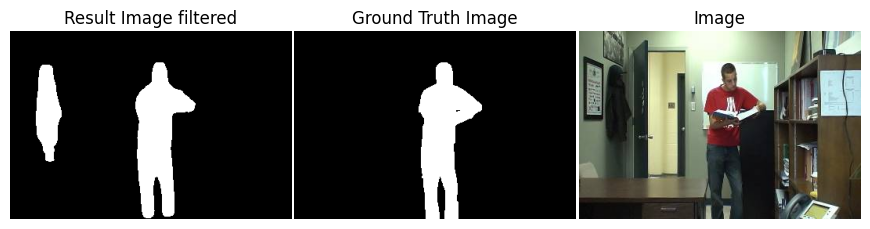

In [33]:
# Choose a single image to display and analyze
THRESHOLDS = [0.40]
exec_types = ['unfiltered','filtered']
dataset_name = 'office'
image_number = '001565'

path = r'C:\Users\arnau\OneDrive\Documents\GitHub\TP_INF6804\TP2\dataset\baseline'
path_dataset = os.path.join(path, dataset_name)
path = os.path.join(path_dataset, 'input')
path_gt = os.path.join(path_dataset, 'groundtruth')

preprocess = transforms.Compose([transforms.ToTensor()])
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

for THRESHOLD in THRESHOLDS:
    
    result_df = pd.DataFrame(columns = ['image','UOI','F1_precision_recall'])
    tensors = []
    image_path = path + '/in' + image_number + '.jpg'
    gt_path = path_gt + '/gt' + image_number + '.png'
    image_list = []
    for execution_type in exec_types:
        img = io.imread(image_path)
        img_gt = (io.imread(gt_path) != 0).astype(int)

        tensors.append(preprocess(img))
        
        prediction = model(tensors)[0]
        image = tensors[0].permute(1,2,0).mul(255).byte().numpy() # permute est equivalent a faire deux tranpose : ici permute(1,2,0) peut etre remplacee par transpose(0, 1).transpose(1, 2)
        image[:,:] = 0
        nb_objects=0
    
        for j, score in enumerate(prediction['scores']):
            if score >= THRESHOLD: 
                mask = prediction['masks'][j][0].detach().numpy()
                colored_mask, color = draw_colored_masks(mask)
                
                if execution_type == 'filtered':
                    object_label = 1
                    if dataset_name == 'highway':
                        object_label = 3
                elif execution_type == 'unfiltered':
                    object_label = prediction['labels'][j]
                else:
                    print('execution type not defined properly: type filtered or unfiltered') 
                    break
                
                if prediction['labels'][j] == object_label:#Filters out irrelevant objects (label 3 for cars and label 1 for people)
                    image = image + cv2.addWeighted(image, 0, colored_mask, 1, 0)
                    nb_objects+=1
                    
        image = (image != 0).astype(int)            
        new_row = [image_number, IOU_score(img_gt, image), F1_score(img_gt, image)]
        result_df.loc[len(result_df.index)] = new_row
        image_list.append(image)
        
        _, _, uoi_score = zip(*result_df['UOI'])
        print( zip(*result_df['F1_precision_recall']))
        f1_score, precision_score, recall_score = zip(*result_df['F1_precision_recall'])
        uoi_score_avg = np.mean(uoi_score)
        f1_score_avg = np.mean(f1_score)
        precision_score_avg = np.mean(precision_score)
        recall_score_avg = np.mean(recall_score)
            
        print('threshold',THRESHOLD)
        print('UOI score is :', uoi_score_avg)
        print('F1 score is :', f1_score_avg)
        print('Precision score is : ', precision_score_avg)
        print('Recall score is :', recall_score_avg)
        print('-----------------------------')
        if execution_type == 'filtered':
            print('label of interest: ',object_label)
        print('number of objects identified: ', nb_objects)
        print('prediction label', prediction['labels'])
        
    # Show last results side by side
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.01)


    # Display the result image
    """
    plt.subplot(1, 4, 1)
    plt.imshow(255*image_list[0], cmap=plt.get_cmap('binary'))
    plt.axis('off')
    plt.title('Result Image unfiltered')
    """
    # Display the result image
    plt.subplot(1, 3, 1)
    plt.imshow(255*image_list[1], cmap=plt.get_cmap('binary'))
    plt.axis('off')
    plt.title('Result Image filtered')

    # Display the ground truth image
    plt.subplot(1, 3, 2)
    plt.imshow(255*img_gt, cmap=plt.get_cmap('binary'))
    plt.axis('off')
    plt.title('Ground Truth Image')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')

    plt.show()

Display predictions on images. A prediction includes a mask, a bounding box, a class label and a confidence score. Here we show only predictions with a score higher than the threshold (0.95)

In [10]:
# Compilation des résultats
_, _, _, uoi_score = zip(*result_df['UOI'])
uoi_score_avg = np.mean(uoi_score)
f1_score_avg = np.mean(result_df['F1'])
print('UOI score is :', uoi_score_avg)
print('F1 score is :', f1_score_avg)

UOI score is : 78.8909723160027
F1 score is : 54.40310600945307


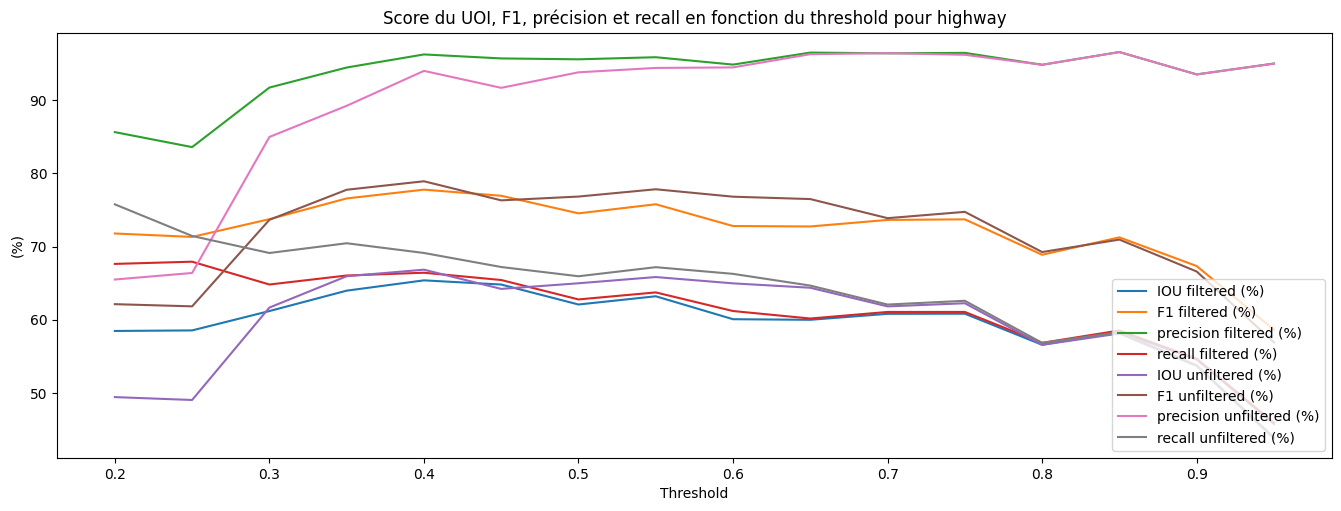

In [25]:
# Summary plot
# Change path and plot title

df_filtered = pd.read_csv('summary_highway_filtered.csv')
df_unfiltered = pd.read_csv('summary_highway_unfiltered.csv')

for index, row in df_filtered.iterrows():
    float_list_precision_filt = [float(x) for x in row['precision'][1:-1].split(",")]
    float_list_recall_filt = [float(x) for x in row['recall'][1:-1].split(",")]
    
    # Calculate the mean of the float values and assign it to the 'precision' column
    df_filtered.at[index, 'precision'] = np.mean(float_list_precision_filt)
    df_filtered.at[index, 'recall'] = np.mean(float_list_recall_filt)
    
for index, row in df_unfiltered.iterrows():
    float_list_precision_unfilt = [float(x) for x in row['precision'][1:-1].split(",")]
    float_list_recall_unfilt = [float(x) for x in row['recall'][1:-1].split(",")]
    
    # Calculate the mean of the float values and assign it to the 'precision' column
    df_unfiltered.at[index, 'precision'] = np.mean(float_list_precision_unfilt)
    df_unfiltered.at[index, 'recall'] = np.mean(float_list_recall_unfilt)


plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.01)
plt.plot(df_filtered['Threshold'],100* df_filtered['UOI'], label = 'IOU filtered (%)')
plt.plot(df_filtered['Threshold'],100* df_filtered['F1'], label = 'F1 filtered (%)')
plt.plot(df_filtered['Threshold'],100* df_filtered['precision'], label = 'precision filtered (%)')
plt.plot(df_filtered['Threshold'],100* df_filtered['recall'], label = 'recall filtered (%)')

plt.plot(df_filtered['Threshold'],100* df_unfiltered['UOI'], label = 'IOU unfiltered (%)')
plt.plot(df_filtered['Threshold'],100* df_unfiltered['F1'], label = 'F1 unfiltered (%)')
plt.plot(df_filtered['Threshold'],100* df_unfiltered['precision'], label = 'precision unfiltered (%)')
plt.plot(df_filtered['Threshold'],100* df_unfiltered['recall'], label = 'recall unfiltered (%)')
plt.xlabel('Threshold')
plt.ylabel('(%)')
plt.title('Score du UOI, F1, précision et recall en fonction du threshold pour highway')
plt.legend(loc = 'lower right')
plt.show()

**References:**
 - https://pytorch.org/docs/stable/torchvision/models.html

 - [Mask R-CNN paper](https://arxiv.org/abs/1703.06870)